# Reproducible Hydrological Modeling with CyberGIS-Jupyter For Water (CJW) and HydroShare

#### Fangzheng Lyu, Zhiyu Li, Anand Padmanabhan, Shaowen Wang, Youngdon Choi, Jonathan Goodall, Andrew Bennett, Bart Nijssen, David Tarboton

CyberGIS-Jupyter for Water (CJW), leveraging the cyberGIS software ecosystem, is integrated with HydroShare. CJW provides a collaborative platform for enabling computationally intensive and reproducible hydrologic research by delivering advanced cyberinfrastructure and cyberGIS capabilities based on high-performance computing (HPC) resources such as Virtual ROGER and XSEDE Comet. The Structure For Unifying Multiple Modeling Alternatives [(SUMMA)](https://ral.ucar.edu/projects/summa), which is a hydrological modeling framework, allows for formal evaluation of multiple working hypotheses on model representations of physical processes. This CyberGIS-Jupyter notebook illustrates specific support for a SUMMA model on top of the cutting-edge hydrologic modeling capabilities on CJW. By taking advantage of CJW, users can easily tune different parameters for a SUMMA model and submit computationally intensive High-Throughput Computing (HTC) jobs for executing the model on HPC resources via Jupyter notebooks without having to possess in-depth technical knowledge about cyberGIS or HydroShare. Computational experiments demonstrate that the integration of cyberGIS capabilities and HydroShare achieves a high-performance and easy-to-use environment for reproducible SUMMA-based hydrological modeling.

# Notebook Outline
- [The Structure For Unifying Multiple Modeling Alternatives (SUMMA)](#summa)
- [Architecture](#arch)
- [Retrieve resources](#resources)
- [Unzip model instance package](#unzip)
- [Install SUMMA model](#install)
- [Use pySUMMA to build ensembles](#build)
- [Submit model](#submit)
- [Check model output](#check)
- [Plot the output](#plot)
    - [Leaf Area Index & ET](#LAI)
    - [stomatal resistance & ET](#stomatal)
- [Cleanup](#cleanup)

<a id='summa'></a>
## The Structure For Unifying Multiple Modeling Alternatives (SUMMA)

SUMMA or the Structure for Unifying Multiple Modeling Alternatives is a hydrologic modeling approach that is built on a common set of conservation equations and a common numerical solver, which together constitute the structural core of the model. Different modeling approaches can then be implemented within the structural core, enabling a controlled and systematic analysis of alternative modeling options, and providing insight for future model development.
1. The formulation of the conservation equations is cleanly separated from their numerical solution;
2. Different model representations of physical processes (in particular, different flux parameterizations) can be used within a common set of conservation equations; and
3. The physical processes can be organized in different spatial configurations, including model elements of different shape and connectivity (e.g., nested multi-scale grids and HRUs)

<a id='arch'></a>
## Architecture of Job Submission System

The architecture of job submission system is listed as follows. The architecture of the integrated system enables interactions among three key entities: users, CyberGIS-Jupyter, and HPC resources provided through XSEDE (e.g. Comet). In addition, there are four supporting components with which the key entities interact with: 1) external authentication system, 2) HydroShare for hydrological data retrieval, 3) JupyterHub with appropriate cyberGIS and geospatial python libraries installed, and 4) Docker hub for SUMMA singularity image. HydroShare is a collaborative research platform for advancing hydrological data and model sharing.

<img src="Picture/SUMMA_Architecture.png" width="800">

<a id='resources'></a>
## Retrieve a SUMMA model instance resource from HydroShare

This is the resource id of a HydroShare composite resource that contains a SUMMA model instance. More information on this [resource](https://www.hydroshare.org/resource/1f3f310af8364d2aa3e6a9459152a21c/)

In [38]:
# Indicate the resource ID
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'

We use HydroShare REST API Python client (hs_restclient) to retrieve the above resource onto the notebook server

In [39]:
# Import json, os, hs_restclient, subprocess library
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
import subprocess
# Connect with HydroShare
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
# Dictionary path
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = "/home/jovyan/shared_data/data/tmp_job_submit"
# Get the metadata of the resource
metadata = hs.getScienceMetadata(resource_id)
timestamp = resource_id+";"+metadata['dates'][1]['start_date']
# Test if the file is located in the shared folder
out = subprocess.Popen(['ls',  '/home/jovyan/shared_data/data/tmp_job_submit'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)
stdout,stderr = out.communicate()
out2 = subprocess.Popen(['grep', timestamp, '/home/jovyan/shared_data/data/tmp_job_submit/managementfile'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)
stdout2,stderr2 = out2.communicate()
# when the resource is not available in the shared folder
if (resource_id.encode("utf-8") not in stdout or stdout2==b""):
    print("Downloading Data")
    #!mkdir -p {download_dir}
    hs.getResource(resource_id, destination=download_dir, unzip=True)
    with open('/home/jovyan/shared_data/data/tmp_job_submit/managementfile', 'a') as file:
        file.write(timestamp)
print("Done")

Done


<a id='unzip'></a>
## Unzip model instance package

Create a temporary local folder and unzip the SUMMA instance

In [40]:
# Import os, tempfile library
import os
import tempfile
# Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance_sopron"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance_sopron.zip
   creating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/
   creating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/
   creating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/
  inflating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc  
  inflating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson  
   creating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/
  inflating: /home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFl

<a id='install'></a>
## Install SUMMA model on Jupyter server (configure path in summa file_manager)

By default, the file_manager file of the SUMMA instance does not contain local path. Need to use script to install it locally.

In [41]:
# Install the testcases
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


<a id='build'></a>
## Use pySUMMA to build ensembles

We create an empty "summa_zParamTrial_riparianAspen.nc" file so later we can do ensemble analysis on parameters

In [42]:
# Create a empty ParamTrial.nc file (required by parameter ensemble)
import netCDF4 as nc
name = os.path.join(model_source_folder_path, 'settings/summa_zParamTrial_riparianAspen.nc')
print(name)
param_trial = nc.Dataset(name, "w", format="NETCDF3_CLASSIC")
param_trial.createDimension("hru", 1)
param_trial.close()

/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/summa_zParamTrial_riparianAspen.nc


Build the ensemble cases: here we create a combination of different stomResist types, rootDistExp values and summerLAI values with help from PySumma. The total ensemble number is 75. We then save the 75 cases into a json file named "summa_options.json"

In [43]:
# Import library
import numpy as np
import json
from pysumma import ensemble

def safe_arange(start, stop, step):
    a = np.arange(start, stop, step)
    result =[]
    for i in a:
        par = round(i, 10)
        result = np.append(result, par)
    return result

# create ensemble
# different parameterizations
decision_options = {
    "stomResist": ["BallBerry", "Jarvis", "simpleResistance"]
}
# different parameters
param_options = {
   'rootDistExp': safe_arange(0.01, 1.00, 0.20),
   'summerLAI': safe_arange(0.01, 10.00, 2.00)
}

config = ensemble.total_product(dec_conf=decision_options, param_conf=param_options)

# save ensemble info to json file
with open(os.path.join(model_source_folder_path, 'summa_options.json'), 'w') as outfile:
    json.dump(config, outfile)

# check ensemble parameters    
print("Number of ensemble runs: {}".format(len(config)))
print(json.dumps(config, indent=4, sort_keys=True)[:800])
print("...")

Number of ensemble runs: 75
{
    "++BallBerry++rootDistExp=0.01++summerLAI=0.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 0.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=2.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 2.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=4.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 4.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=6.01++": {
        "decisions": {
            "stomRe
...


<a id='submit'></a>
## Submit model to XSEDE Comet HPC using CyberGIS-Jupyter tool

We use cybergis lib to submit the HTC SUMMA model to High-Performance Computer as a job

In [44]:
## Submit the job directly without UI
from cybergis import HPCSUMMA
dict_ = {}
dict_["model"] = "summa"
dict_["model_source_folder_path"] = model_source_folder_path
dict_["file_manger_rel_path"] = file_manger_rel_path
dict_["workspace_dir"] = workspace_dir
dict_["machine"] = "keeling"
dict_['node'] = 16
dict_['walltime'] = 1

para_json_str = json.dumps(dict_)

s = HPCSUMMA(para_json_str)
s.run()

2020-05-12 07:34:21,183 [MainThread  ] [INFO ]  SSH logged into keeling.earth.illinois.edu as user cigi-gisolve
2020-05-12 07:34:21,199 [MainThread  ] [INFO ]  Uploading /home/jovyan/work/workspace/Summa_1589268859_35011879 to /data/keeling/a/cigi-gisolve
2020-05-12 07:34:25,461 [MainThread  ] [INFO ]  Submitting Job summa.sbatch to queue
2020-05-12 07:34:25,794 [MainThread  ] [INFO ]  Remote Job ID assigned: 3548805
2020-05-12 07:34:29,253 [MainThread  ] [INFO ]  R
2020-05-12 07:34:32,778 [MainThread  ] [INFO ]  R
2020-05-12 07:34:36,238 [MainThread  ] [INFO ]  R
2020-05-12 07:34:39,732 [MainThread  ] [INFO ]  R
2020-05-12 07:34:43,178 [MainThread  ] [INFO ]  R
2020-05-12 07:34:46,657 [MainThread  ] [INFO ]  R
2020-05-12 07:34:50,167 [MainThread  ] [INFO ]  R
2020-05-12 07:34:53,618 [MainThread  ] [INFO ]  R
2020-05-12 07:34:57,123 [MainThread  ] [INFO ]  R
2020-05-12 07:35:00,620 [MainThread  ] [INFO ]  R
2020-05-12 07:35:04,078 [MainThread  ] [INFO ]  R
2020-05-12 07:35:07,616 [Main

Walltime (hour) is the maximum duration of time the job is allowed to run on the HPC before it gets killed.
Nodes indicate the number of CPU cores will be allocated for this job. CyberGIS lib will run the job over the assigned CPUs in parallel. If you select 16 nodes, then each node will run about 4-5 cases out of the 75-member ensemble

<a id='check'></a>
## Check model output  -- NetCDF files

Once job finishes execution on HPC, cybergis lib will retrieve the results back to notebook server. Each ensemble member will create a separate nc file, so there are 75 netcdf files in this case.

In [45]:
# check output directory
job_dir = os.path.join(workspace_dir, "{}".format(s.job_local_id))
output_path = os.path.join(job_dir, "output")
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list if i.endswith(".nc")]
sorted_list = sorted(full_list)

for f in sorted_list:
    print(f)
print("Number of NC files: {}".format(len(sorted_list)))

/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=2.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=4.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=6.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=8.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.21++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1589268859_35011879/output/vegImpactsTranspire_output_++BallBerry++rootDistExp

<a id='plot'></a>
## Plot time series for total evapotranspiration (total ET)

Here we define a functions that can read in a list of Summa output nc files, calculate Total evapotranspiration and plot it

In [46]:
# Import library
%matplotlib inline
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import numpy as np

#  Function to calculate the total evapotranspiration
def calc_total_et(et_output_df):
    total_et_data = (et_output_df['scalarLatHeatTotal'])*3600/2260000
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-05-31 23:00:00":"2007-08-20 23:00:00"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    total_et_by_hour.index.name = 'hour'
    total_et_by_hour.columns = ['ET']
    # calculate 3 hour moving average
    total_et_by_hour.loc[24] = total_et_by_hour.loc[0].values
    for index in range(1,24,1):
        total_et_by_hour['ET'][index] = (total_et_by_hour['ET'][index-1]+total_et_by_hour['ET'][index]+total_et_by_hour['ET'][index+1])/3
    return total_et_by_hour

In [47]:
def plot_ET1(nc_list):
    
    dataset_list = [calc_total_et(xr.open_dataset(nc)) for nc in nc_list]
    ET_Combine = pd.concat(dataset_list, axis=1)
    ET_Combine_Graph = ET_Combine.plot(linewidth=3.0,figsize=(12,10))
    # invert y axis
    ET_Combine_Graph.invert_yaxis()

    # add x, y label
    plt.xlabel('Time of day (hr)', fontsize=25)
    plt.ylabel('Total evapotranspiration (mm/h)', fontsize=25)
    # show up the legend
    legends = []
    for nc in nc_list:
        legends.append(os.path.basename(nc))
    #for lengend in legends:
    legend = []
    for lists in legends:
        list = lists.split("++")[3]
        legend.append(list)
    ET_Combine_Graph.legend(legend, fontsize=20, loc=2)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

<a id='LAI'></a>
### How do different  Leaf Area Index (summerLAI) values affect total ET?

Here we plot the ET results for different summaLAI by setting stomResist to BallBerry and rootDistExp=0.21

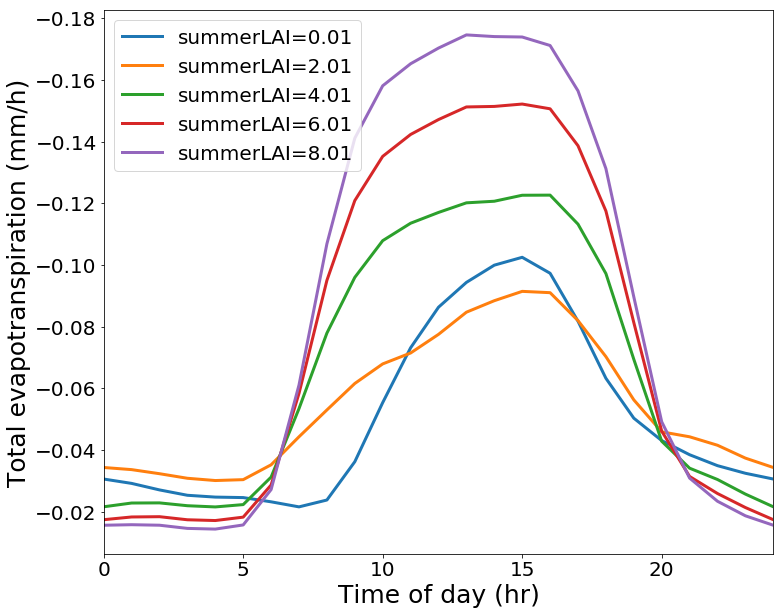

In [48]:
subset = [x for x in sorted_list if 'BallBerry++rootDistExp=0.21' in x]
plot_ET1(subset)

<a id='stomatal'></a>
### How do different  stomatal resistance parameterizations affect total ET?

Here we only plot the ET results for different stomResist types by setting rootDistExp=0.21 and summerLAI to 4.01

In [49]:
def plot_ET1(nc_list):
    
    dataset_list = [calc_total_et(xr.open_dataset(nc)) for nc in nc_list]
    ET_Combine = pd.concat(dataset_list, axis=1)
    ET_Combine_Graph = ET_Combine.plot(linewidth=3.0,figsize=(12,10))
    # invert y axis
    ET_Combine_Graph.invert_yaxis()

    # add x, y label
    #ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1)', fontsize=25)
    plt.xlabel('Time of day (hr)', fontsize=25)
    plt.ylabel('Total evapotranspiration (mm/h)', fontsize=25)
    # show up the legend
    legends = []
    for nc in nc_list:
        legends.append(os.path.basename(nc))
    #for lengend in legends:
    legend = []
    for lists in legends:
        list = lists.split("++")[1]
        legend.append(list)
    ET_Combine_Graph.legend(legend, fontsize=20, loc=2)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

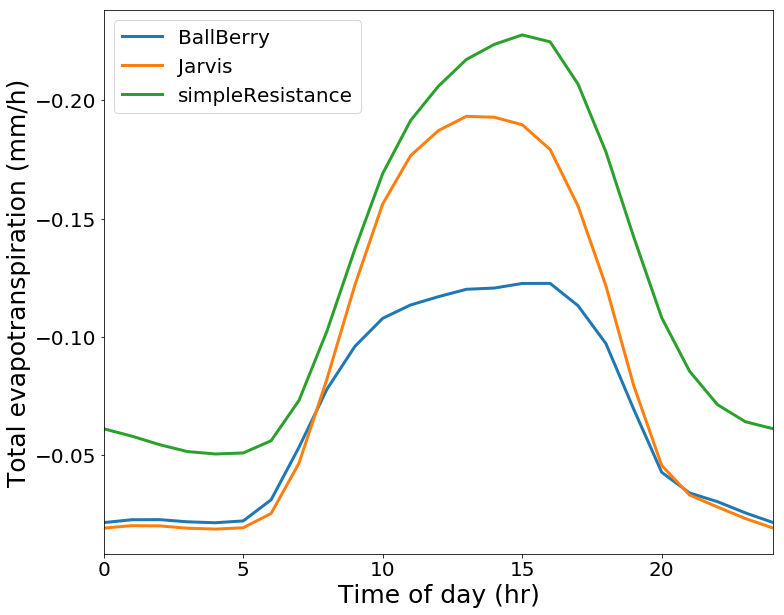

In [50]:
subset = [x for x in sorted_list if 'rootDistExp=0.21++summerLAI=4.01' in x]
plot_ET1(subset)

<a id='cleanup'></a>
## Cleanup

This step is optional, which will remove all model outputs on notebook server

In [51]:
! rm -rvf {unzip_dir} {job_dir}

removed '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc'
removed directory '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData'
removed '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson'
removed '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFlux.nc'
removed directory '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData'
removed directory '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data'
removed '/home/jovyan/work/workspace/tmpnq7nh1eh/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/installTestCases_local.sh'
removed directory '/home/jovyan/work/

# Done